In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *
from lifelines import KaplanMeierFitter, CoxPHFitter
import math

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


In [2]:
def missing_impute(y, missing_to_num=-1):
    y_outcome = copy.deepcopy(y)
    event_indicator = (y_outcome>0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_outcome[mask] = missing_to_num
    return y_outcome

def long_to_surv(y):
    num_individuals, num_time_points = y.shape
    times = []
    events = []

    for i in range(num_individuals):
        individual = y[i].tolist()
        try:
            # Find the index of the first event (1)
            event_time = individual.index(1) + 1  # +1 if time starts at 1
            event = 1
        except ValueError:
            # If no event occurred, censor at the last time point
            event_time = num_time_points
            event = 0
        
        times.append(event_time)
        events.append(event)

    df = pd.DataFrame({
        'time': times,
        'event': events,
    })
    return df

# With C included

In [3]:
s,x,z,y = generate_data_survivl(n=10000,T=10, random_seed=42, C_coeff=0.5)
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=6000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.5500,	loss_y 1.5548, 1.5701, 0.0306,	loss_eta 2.9951, 3.0983, 0.2063
Epoch 1000: loss 2.9946,	loss_y 0.8099, 1.4569, 1.2941,	loss_eta 2.1847, 4.3494, 4.3293
Epoch 2000: loss 2.9138,	loss_y 0.7228, 1.3452, 1.2449,	loss_eta 2.1911, 4.3489, 4.3157
Epoch 3000: loss 2.8028,	loss_y 0.6293, 1.1918, 1.1251,	loss_eta 2.1735, 4.3402, 4.3333
Epoch 4000: loss 2.7667,	loss_y 0.5821, 1.1043, 1.0445,	loss_eta 2.1846, 4.3548, 4.3404
Epoch 5000: loss 2.7277,	loss_y 0.5506, 1.0467, 0.9922,	loss_eta 2.1771, 4.3501, 4.3460
Epoch 6000: loss 2.7204,	loss_y 0.5269, 1.0025, 0.9511,	loss_eta 2.1934, 4.3688, 4.3508


In [60]:

torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=1000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.05+0.5*C  # mean parameter
mu_x1 = 0.55+0.5*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

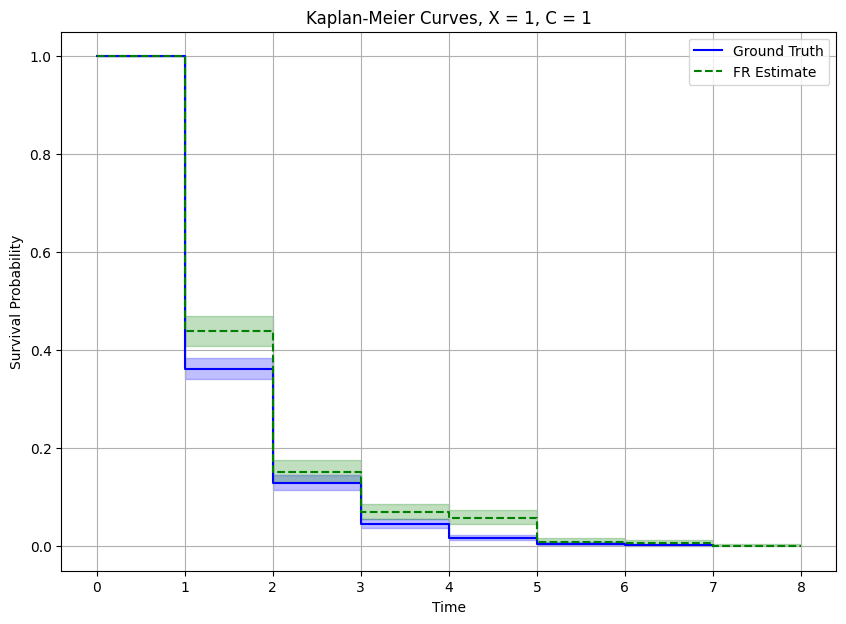

In [61]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

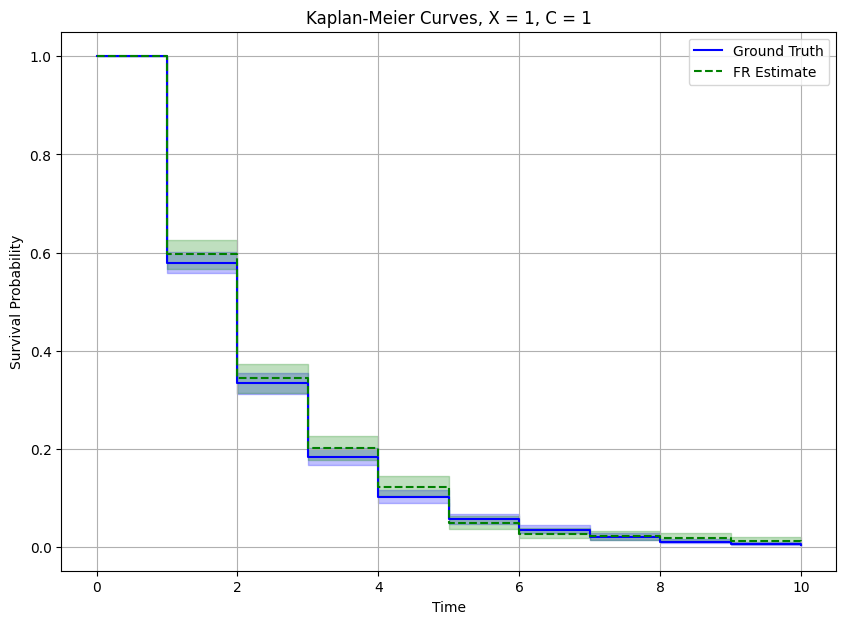

In [62]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()